In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from scipy.stats import randint

In [3]:
#loading data
spaceship=pd.read_csv("train.csv")


# Basic Data Exploration

In [4]:
#explore Data
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
spaceship.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
spaceship.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


<function matplotlib.pyplot.show(close=None, block=None)>

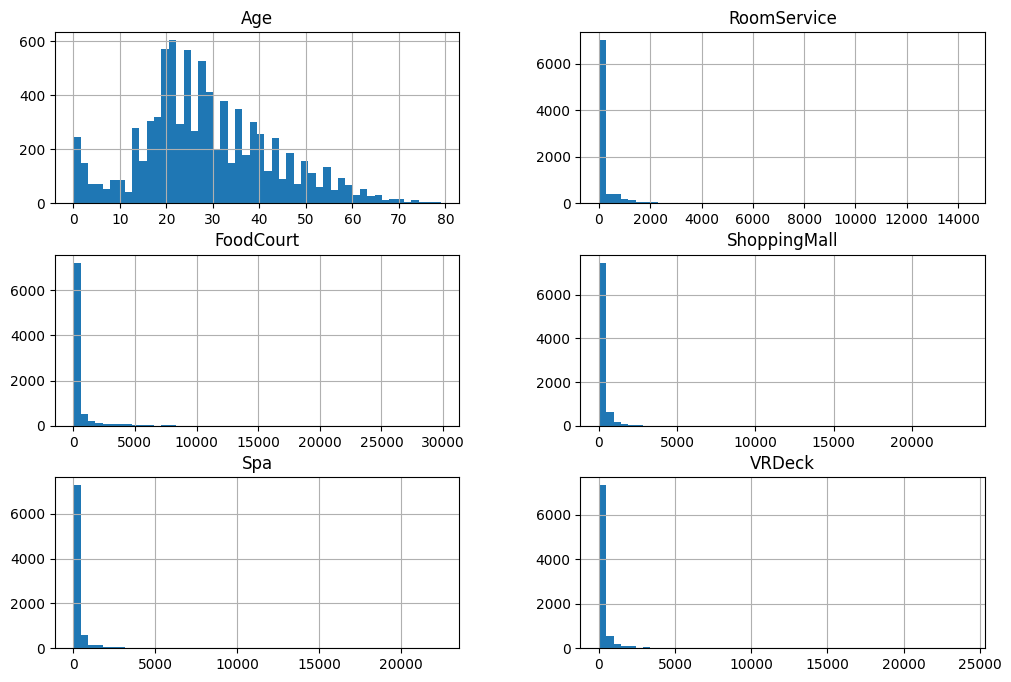

In [6]:
spaceship.hist(bins=50, figsize=(12,8))
plt.show

# Feature Engineering

In [7]:
#feature engineering
spaceship["spending_overall"]= spaceship["RoomService"]+spaceship["FoodCourt"]+spaceship["ShoppingMall"]+spaceship["Spa"]+spaceship["VRDeck"]
spaceship["spending_category"]=pd.cut(spaceship["spending_overall"], bins=[0., 5000., 10000., 15000., 20000., 25000., 30000., np.inf], labels=[1,2,3,4,5,6,7])
spaceship["spending_category"].fillna(1, inplace=True)
spaceship.dropna(subset=["Cabin"],inplace=True)
spaceship["Deck"]= spaceship["Cabin"].astype(str).str[0]
spaceship= spaceship.drop(["Name", "PassengerId", "Cabin"], axis=1)
spaceship.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,spending_overall,spending_category,Deck
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,1,B
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,736.0,1,F
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,10383.0,3,A
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,5176.0,2,A
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1091.0,1,F


# Data Splitting

In [8]:
#Splitting the Data 
train_set, test_set =train_test_split(spaceship, test_size=0.2,stratify=spaceship["Deck"],  random_state=42)

training_features = train_set.drop("Transported", axis=1)
training_labels = train_set["Transported"].copy()

testing_features = test_set.drop("Transported", axis=1)
testing_labels = test_set["Transported"].copy()

# Preprocessing via Pipelines

In [9]:
#preprocessing
num_pipeline= Pipeline([("Impute", SimpleImputer(strategy="median"))
                        ,("Scaling", StandardScaler())])
cat_pipeline= Pipeline([("Impute", SimpleImputer(strategy="most_frequent")),
                        ("Encoding", OneHotEncoder())
                        ])
log_pipeline= Pipeline([("Impute", SimpleImputer(strategy="median")),
                        ("Log-Transformer", FunctionTransformer(np.log)),
                        ("Scaling", StandardScaler())])
preprocessing= ColumnTransformer([
    #("log", log_pipeline, ["spending_overall"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ], remainder=num_pipeline)

training_features_prepared = preprocessing.fit_transform(training_features)
testing_features_prepared = preprocessing.transform(testing_features)

preprocessing.get_feature_names_out()

array(['cat__HomePlanet_Earth', 'cat__HomePlanet_Europa',
       'cat__HomePlanet_Mars', 'cat__CryoSleep_False',
       'cat__CryoSleep_True', 'cat__Destination_55 Cancri e',
       'cat__Destination_PSO J318.5-22', 'cat__Destination_TRAPPIST-1e',
       'cat__VIP_False', 'cat__VIP_True', 'cat__Deck_A', 'cat__Deck_B',
       'cat__Deck_C', 'cat__Deck_D', 'cat__Deck_E', 'cat__Deck_F',
       'cat__Deck_G', 'cat__Deck_T', 'remainder__Age',
       'remainder__RoomService', 'remainder__FoodCourt',
       'remainder__ShoppingMall', 'remainder__Spa', 'remainder__VRDeck',
       'remainder__spending_overall', 'remainder__spending_category'],
      dtype=object)

# Creating Models
Goal: finding 3 promising models for fine-tuning

In [10]:
#creating models
rfc_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
svm_model = SVC(random_state=42)
knn_model = KNeighborsClassifier()
nb_model = GaussianNB()
sgd_model = SGDClassifier(random_state=42)

models={'Random Forest Classifier':rfc_model, 'Logistic Regression':lr_model, 'Decision Tree Model':dt_model,
        'SVM Model': svm_model,'KNN Model': knn_model,'naive Bayes Model': nb_model, 'SG Descent Model' : sgd_model}


# Finding Promising Model Shortlist

In [11]:
for name, model in models.items():
    model.fit(training_features_prepared, training_labels)
    accuracy_train=accuracy_score(training_labels, model.predict(training_features_prepared))
    accuracy_test=accuracy_score(testing_labels, model.predict(testing_features_prepared))
    f1_train= f1_score(training_labels, model.predict(training_features_prepared))
    f1_test=f1_score(testing_labels, model.predict(testing_features_prepared))
    print(f"Accuracy on Training Data/Testing Data of the {name} is {accuracy_train:.4f}/ {accuracy_test:.4f} \nF1 is {f1_train:.4f}/ {f1_test:.4f} ")
  

Accuracy on Training Data/Testing Data of the Random Forest Classifier is 0.9416/ 0.8111 
F1 is 0.9434/ 0.8088 
Accuracy on Training Data/Testing Data of the Logistic Regression is 0.7841/ 0.8134 
F1 is 0.7885/ 0.8177 
Accuracy on Training Data/Testing Data of the Decision Tree Model is 0.9416/ 0.7487 
F1 is 0.9426/ 0.7561 
Accuracy on Training Data/Testing Data of the SVM Model is 0.7990/ 0.8164 
F1 is 0.7983/ 0.8127 
Accuracy on Training Data/Testing Data of the KNN Model is 0.8275/ 0.7916 
F1 is 0.8288/ 0.7927 
Accuracy on Training Data/Testing Data of the naive Bayes Model is 0.7305/ 0.7681 
F1 is 0.7677/ 0.7988 
Accuracy on Training Data/Testing Data of the SG Descent Model is 0.7765/ 0.7946 
F1 is 0.7697/ 0.7904 


The three most promising Models are Random Forest Classifier, Linear Regression, SVM Model and KNN. Random Forest Classifier is severly overfitted, but still performs quite well. In the scneario of the data set, there is no particular reason to prefer precision over recall or vice versa. Therefore we will opt for a balanced score (a good f1 score).

# Model Fine Tuning

In [12]:
param_distribs_rf= {'random_forest__n_estimators': randint(low=20, high=200),
                    'random_forest__max_features' : randint(low=2, high=30),
                    'random_forest__max_depth': randint(low=5, high= 100)}

full_pipeline_rf= Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=11))
     ])
rnd_search= RandomizedSearchCV(
    full_pipeline_rf, param_distributions=param_distribs_rf, cv=3, scoring="f1", random_state=42
)
rnd_search.fit(training_features, training_labels)
rnd_search.best_params_

{'random_forest__max_depth': 56,
 'random_forest__max_features': 16,
 'random_forest__n_estimators': 126}

In [13]:
param_distribs_svm= {'svm__C': randint(low=0, high=10),
                    'svm__degree' : randint(low=1, high=20)}

full_pipeline_svm= Pipeline([
    ("preprocessing", preprocessing),
    ("svm", SVC(random_state=42))
     ])
rnd_search= RandomizedSearchCV(
    full_pipeline_svm, param_distributions=param_distribs_svm, cv=3, scoring="f1", random_state=42
)
rnd_search.fit(training_features, training_labels)
rnd_search.best_params_

{'svm__C': 6, 'svm__degree': 15}

In [14]:
param_distribs_lr= {'log_regression__C': randint(low=0, high=5)}

full_pipeline_lr= Pipeline([
    ("preprocessing", preprocessing),
    ("log_regression", LogisticRegression(random_state=42))
     ])
rnd_search= RandomizedSearchCV(
    full_pipeline_lr, param_distributions=param_distribs_lr, cv=3, scoring="f1", random_state=42
)
rnd_search.fit(training_features, training_labels)
rnd_search.best_params_

{'log_regression__C': 3}

In [19]:
param_distribs_knn= {'KNN__n_neighbors': randint(low=2, high=20)}

full_pipeline_knn= Pipeline([
    ("preprocessing", preprocessing),
    ("KNN", KNeighborsClassifier())
     ])
rnd_search= RandomizedSearchCV(
    full_pipeline_knn, param_distributions=param_distribs_knn, cv=3, scoring="f1", random_state=42
)
rnd_search.fit(training_features, training_labels)
rnd_search.best_params_

{'KNN__n_neighbors': 9}

In [13]:
#creating models
rfc_model = RandomForestClassifier(n_estimators=21, max_features=8, random_state=11)
lr_model = LogisticRegression(C=3,random_state=42)
svm_model = SVC(C=6, degree=15, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=9)


In [21]:
candidates={'Random Forest Classifier':rfc_model, 'Logistic Regression':lr_model,
        'SVM Model': svm_model, 'KNN Model' : knn_model}

## Final Scores of Training Data 

In [24]:
for name, model in candidates.items():
    train_pred=cross_val_predict(model, training_features_prepared, training_labels, cv=3)
    cm = confusion_matrix(training_labels, train_pred)
    prec=precision_score(training_labels, train_pred)
    recall=recall_score(training_labels, train_pred)
    f1=f1_score(training_labels, train_pred)
    print(f"The Confusion Matrix of {name} looks like \n {cm} \n precision is {prec}, recall is {recall} and f1 is {f1}")

The Confusion Matrix of Random Forest Classifier looks like 
 [[2720  661]
 [ 843 2571]] 
 precision is 0.7954826732673267, recall is 0.7530755711775043 and f1 is 0.7736984652422509
The Confusion Matrix of Logistic Regression looks like 
 [[2594  787]
 [ 701 2713]] 
 precision is 0.7751428571428571, recall is 0.7946690099589924 and f1 is 0.7847844952270755
The Confusion Matrix of SVM Model looks like 
 [[2689  692]
 [ 772 2642]] 
 precision is 0.7924415116976604, recall is 0.7738722905682484 and f1 is 0.7830468286899822
The Confusion Matrix of KNN Model looks like 
 [[2547  834]
 [ 794 2620]] 
 precision is 0.7585408222350898, recall is 0.7674282366725249 and f1 is 0.762958648806057


## Final Scores of Testing Data 

In [25]:
for name, model in candidates.items():
    test_pred=cross_val_predict(model, testing_features_prepared, testing_labels, cv=3)
    cm = confusion_matrix(testing_labels, test_pred)
    prec=precision_score(testing_labels, test_pred)
    recall=recall_score(testing_labels, test_pred)
    f1=f1_score(testing_labels, test_pred)
    print(f"The Confusion Matrix of {name} looks like \n {cm} \n precision is {prec}, recall is {recall} and f1 is {f1}")

The Confusion Matrix of Random Forest Classifier looks like 
 [[690 145]
 [215 649]] 
 precision is 0.8173803526448362, recall is 0.7511574074074074 and f1 is 0.7828709288299156
The Confusion Matrix of Logistic Regression looks like 
 [[659 176]
 [148 716]] 
 precision is 0.8026905829596412, recall is 0.8287037037037037 and f1 is 0.815489749430524
The Confusion Matrix of SVM Model looks like 
 [[685 150]
 [191 673]] 
 precision is 0.8177399756986634, recall is 0.7789351851851852 and f1 is 0.7978660343805573
The Confusion Matrix of KNN Model looks like 
 [[668 167]
 [198 666]] 
 precision is 0.7995198079231692, recall is 0.7708333333333334 and f1 is 0.7849145550972304


It looks like the logistic Regression Model is the most promising out of all the models. Now it is time to make the actual predictions for the "Test" Set given by Kaggle. Let#s call it the submission set. It needs to be preprocessed just like the training set.

In [27]:
#loading data
spaceship_sub=pd.read_csv("test.csv")

In [28]:
#feature engineering
spaceship_sub["spending_overall"]= spaceship_sub["RoomService"]+spaceship_sub["FoodCourt"]+spaceship_sub["ShoppingMall"]+spaceship_sub["Spa"]+spaceship_sub["VRDeck"]
spaceship_sub["spending_category"]=pd.cut(spaceship_sub["spending_overall"], bins=[0., 5000., 10000., 15000., 20000., 25000., 30000., np.inf], labels=[1,2,3,4,5,6,7])
spaceship_sub["spending_category"].fillna(1, inplace=True)
spaceship_sub.dropna(subset=["Cabin"],inplace=True)
spaceship_sub["Deck"]= spaceship_sub["Cabin"].astype(str).str[0]
spaceship_sub= spaceship_sub.drop(["Name", "PassengerId", "Cabin"], axis=1)

In [30]:
submission_features_prepared = preprocessing.fit_transform(spaceship_sub)

In [33]:
lr_model.predict(submission_features_prepared)

array([ True, False,  True, ...,  True,  True,  True])